# **WRF-Python Tutorial - 2025**


## *Douglas Lima de Bem (UFSM/URCA)*


#### **Topics Covered Today**
*   Overview
*   Getting started
*   Use the WRF-Python functions
*   Plotting with WRF-Python using Cartopy and Matplotlib

****

### **What is WRF-Python?**

WRF-Python it is a python library that provide a collection of diagnostic and interpolation routines for use with output from the Weather Research and Forecasting (WRF-ARW) Model.

*   Contains over 30 diagnostic calculations (Cloud Fraction, Updraft Helicity, CAPE, etc.)
*   Several interpolation routines
*   Utilities to help with plotting via cartopy, basemap, or PyNGL


### **Informations and updates of WRF-Python**

To find more information about the utilities and ease of use of WRF-Python, you can search in:



*  [WRF-Python Read the Docs](https://wrf-python.readthedocs.io/en/latest/new.html)
*  [Github Repository](https://github.com/NCAR/wrf-python)
*  [WRF-Python Google Group](https://groups.google.com/a/ucar.edu/g/wrfpython-talk?pli=1)

****

### **Getting Started**
This library, despite being very useful, has not received updates since 2022. There have already been some discussions in the group about the reasons why there have been no updates. Due to this absence, it will have some dependencies that must be taken into account before its use (other libraries that must be used). For this reason, it is recommended to use an environment which contains the necessary versions of the libraries.




*   The versions for the packages being used today will be:

    - wrf-python==1.3.4.1         
    - xarray==2024.9.0
    - netCDF4==1.7.1.post2
    - numpy==1.24.1
    - matplotlib==3.8.4
    - cartopy==0.24.1


**Note**: if your Jupyter Notebook crashes at any point, make sure to re-run the following code cell again before any others.

On your computer, you will (if you already have one) install the libraries via pip, in our case, the libraries that are needed are in the requierements.txt file. So we can:

In [ ]:
%pip install -r requierements.txt

Another alternative is to use an environment via conda with the correct packages. To install conda, you need to download it via the link: 

* [Anaconda](https://www.anaconda.com/download)

After downloading, run the commands:

```sh
chmod 777 anaconda.sh 
./anaconda.sh
```
With this, we can create the environment, using the .yml which is in the folder:

```sh
conda env create -f /PUT/YOUR/PATH/conda_env.yml --name tutorial 
```

Now, we have the complete environment necessary to run and manipulate data using wrf-python.

*****

### **Testing data** 

It is necessary to know if the data we have is being identified by Python, so below we perform a test to validate this.


In [161]:
from __future__ import print_function

# This jupyter notebook command inserts matplotlib graphics in 
# to the workbook
%matplotlib inline

# Modify these to point to your own files
WRF_DIRECTORY = "/home/douglas/WRF-Python/data"
WRF_FILES = ["wrfout_d01_2022-07-16_13:00:00",
             "wrfout_d01_2022-07-16_14:00:00",
             "wrfout_d01_2022-07-16_15:00:00"]

# Do not modify the code below this line
#------------------------------------------------------
# Turn off annoying warnings
import warnings
warnings.filterwarnings('ignore')

# Make sure the environment is good
import numpy as np
import cartopy
from cartopy import crs
from cartopy.feature import NaturalEarthFeature
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray as xr
import os
import glob
import cartopy, cartopy.crs as ccrs        # Plot maps
import cartopy.io.shapereader as shpreader # Import shapefiles
import cmaps
from cpt_convert import loadCPT
from matplotlib.colors import LinearSegmentedColormap 
from matplotlib.colors import from_levels_and_colors
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

from wrf import (getvar, interplevel, vertcross, 
                 CoordPair, ALL_TIMES, to_np,
                 get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim,interpline,ll_to_xy, xy_to_ll)

_WRF_FILES = [os.path.abspath(os.path.expanduser(
    os.path.join(WRF_DIRECTORY, f))) for f in WRF_FILES]

# Check that the WRF files exist
for f in _WRF_FILES:
    if not os.path.exists(f):
        raise ValueError("{} does not exist. "
            "Check for typos or incorrect directory.")

print("All tests passed!")

All tests passed!


### **1) Reading in wrfout files**

Now that all tests have passed, lets try reading in a single wrfout file with netcdf4 and looking at what data it contains.

In [169]:
### Reading a single file and inspect the variables ###

PATH = "/home/douglas/WRF-Python/data/wrfout_d01_2022-07-16_14:00:00"

wrf_file = Dataset(PATH)

var = wrf_file.variables['T2']

print('The temperature at 2m in the domain', var)

var = wrf_file.variables['P'] 

print('The pressure in the domain', var)

# Lets look at a specific attribute, 'coordinates', of that variable
# coords = var.coordinates
# print(coords)

# To see the data presented in the numpy array, we used:

var = var[:]
print('Values of the pressure in the domain',var)

The temperature at 2m in the domain <class 'netCDF4.Variable'>
float32 T2(Time, south_north, west_east)
    FieldType: 104
    MemoryOrder: XY 
    description: TEMP at 2 M
    units: K
    stagger: 
    coordinates: XLONG XLAT XTIME
unlimited dimensions: Time
current shape = (1, 68, 98)
filling on, default _FillValue of 9.969209968386869e+36 used
The pressure in the domain <class 'netCDF4.Variable'>
float32 P(Time, bottom_top, south_north, west_east)
    FieldType: 104
    MemoryOrder: XYZ
    description: perturbation pressure
    units: Pa
    stagger: 
    coordinates: XLONG XLAT XTIME
unlimited dimensions: Time
current shape = (1, 44, 68, 98)
filling on, default _FillValue of 9.969209968386869e+36 used
Values of the pressure in the domain [[[[ 1.03639062e+03  1.01884375e+03  1.00313281e+03 ...  3.92132812e+02
     3.97148438e+02  4.02492188e+02]
   [ 1.03021094e+03  1.00656250e+03  9.89546875e+02 ...  4.01476562e+02
     4.04945312e+02  4.08023438e+02]
   [ 1.02421875e+03  9.99406

### **2) Using WRF-Python Functions**

We will now use the 'getvar' function to process the data from the wrfout file and return a specified variable. This variable can later be used in plotting with Cartopy.


In [82]:
# Use 'wrfin' variable 

# Let's use wrf.getvar() to define and extract "height" variable
hgt = getvar(wrf_file, 'height', timeidx=0) 

print(hgt.shape)
print(hgt)


(44, 68, 98)
<xarray.DataArray 'height' (bottom_top: 44, south_north: 68, west_east: 98)> Size: 1MB
array([[[   63.01128 ,    57.987732,    46.130165, ...,    25.642355,
            25.645031,    25.629402],
        [   66.70955 ,    61.437195,    52.006233, ...,    25.646633,
            25.63202 ,    25.632723],
        [   68.862976,    62.87668 ,    51.361237, ...,    25.627827,
            25.632345,    25.634314],
        ...,
        [   85.28189 ,    86.092224,    87.00812 , ...,   473.16406 ,
           364.01666 ,   338.21548 ],
        [   84.826096,    85.74357 ,    87.09633 , ...,   463.0986  ,
           413.82974 ,   321.4567  ],
        [   84.940254,    85.51405 ,    86.618355, ...,   599.758   ,
           675.7216  ,   508.43246 ]],

       [[  114.55489 ,   109.56076 ,    97.75283 , ...,    79.45799 ,
            79.468346,    79.41064 ],
        [  118.23676 ,   113.00844 ,   103.62063 , ...,    79.47296 ,
            79.4211  ,    79.42501 ],
        [  120.37924 

We can use some arguments in the getvar to modify our data:

In [5]:
# Find sea level pressure (slp)
slp = getvar(wrf_file, 'slp', units='Pa') 
print('Sea Level Pressure in Pascal', slp)

slp = getvar(wrf_file, 'slp', units='mb')
print('Sea Level Pressure in Milibar', slp)

Sea Level Pressure in Pascal <xarray.DataArray 'slp' (south_north: 68, west_east: 98)> Size: 27kB
array([[101019.08 , 101000.14 , 100981.37 , ..., 100500.84 , 100504.02 ,
        100507.69 ],
       [101012.625, 100987.32 , 100968.625, ..., 100504.18 , 100509.945,
        100512.08 ],
       [101005.94 , 100982.3  , 100961.07 , ..., 100507.97 , 100509.414,
        100515.89 ],
       ...,
       [101061.96 , 101046.664, 101031.445, ..., 100989.68 , 100983.12 ,
        101015.23 ],
       [101065.195, 101042.39 , 101026.83 , ..., 100970.89 , 100977.164,
        101010.22 ],
       [101061.766, 101042.34 , 101021.56 , ..., 100962.914, 100977.43 ,
        100967.71 ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 27kB -58.47 -58.37 ... -49.42
    XLAT     (south_north, west_east) float32 27kB -32.35 -32.35 ... -26.93
    XTIME    float32 4B 780.0
    Time     datetime64[ns] 8B 2022-07-16T13:00:00
Dimensions without coordinates: south_north, west_east
Attribute

### **3) Using WRF-Python interpolation routines**

**Four categories of routines**

- *interplevel* =  linear interpolation to a horizontal plane at a specified height or pressure level.
- *vertcross* = vertical cross section interpolation to a vertical plane through two specified points (or a pivot point and angle).
- *vinterp* = interpolates to a "surface", which could be pressure levels or temperature levels like theta-e. A smarter version of interplevel.
- *interpline* = 2-D field interpolated along a line.

### **3.1) Interplevel function**

When we open the WRF 3D variable data, we will have (levels,lat,lon). The interplevel routine has the function to get a field at a specified height or pressure vertical level (500 mb, 5000 m, etc). Uses linear interpolation, which is fast and generally good enough for plotting. 

(**If you want to interpolate using like reference geopotential height, use vinterp**)

In [83]:
u     = getvar(wrf_file, 'ua', timeidx=0)       # 3D U wind [m/s]
v     = getvar(wrf_file, 'va', timeidx=0)       # 3D V wind [m/s]
p     = getvar(wrf_file, 'pressure', timeidx=0)

u850  = interplevel(u, p, 850)
v850  = interplevel(v, p, 850)

ws850 = np.sqrt(u850**2 + v850**2)

print(ws850)

cart_proj = get_cartopy(p)
lats, lons = latlon_coords(p)


<xarray.DataArray (south_north: 68, west_east: 98)> Size: 27kB
array([[10.543698, 10.01041 ,  9.382811, ..., 17.136326, 16.915003,
        16.702797],
       [10.335679,  9.853379,  9.250468, ..., 16.893211, 16.719446,
        16.605286],
       [10.106951,  9.602593,  8.999679, ..., 16.584812, 16.52469 ,
        16.47653 ],
       ...,
       [10.54533 , 10.191105,  9.760012, ..., 24.843647, 24.610104,
        24.125622],
       [10.078461,  9.713957,  9.310162, ..., 25.176329, 24.372551,
        24.43703 ],
       [ 9.60747 ,  9.185353,  8.797355, ..., 24.960722, 23.758503,
        24.54861 ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 27kB -58.47 -58.37 ... -49.42
    XLAT     (south_north, west_east) float32 27kB -32.35 -32.35 ... -26.93
    XTIME    float32 4B 780.0
    Time     datetime64[ns] 8B 2022-07-16T13:00:00
    level    int64 8B 850
Dimensions without coordinates: south_north, west_east


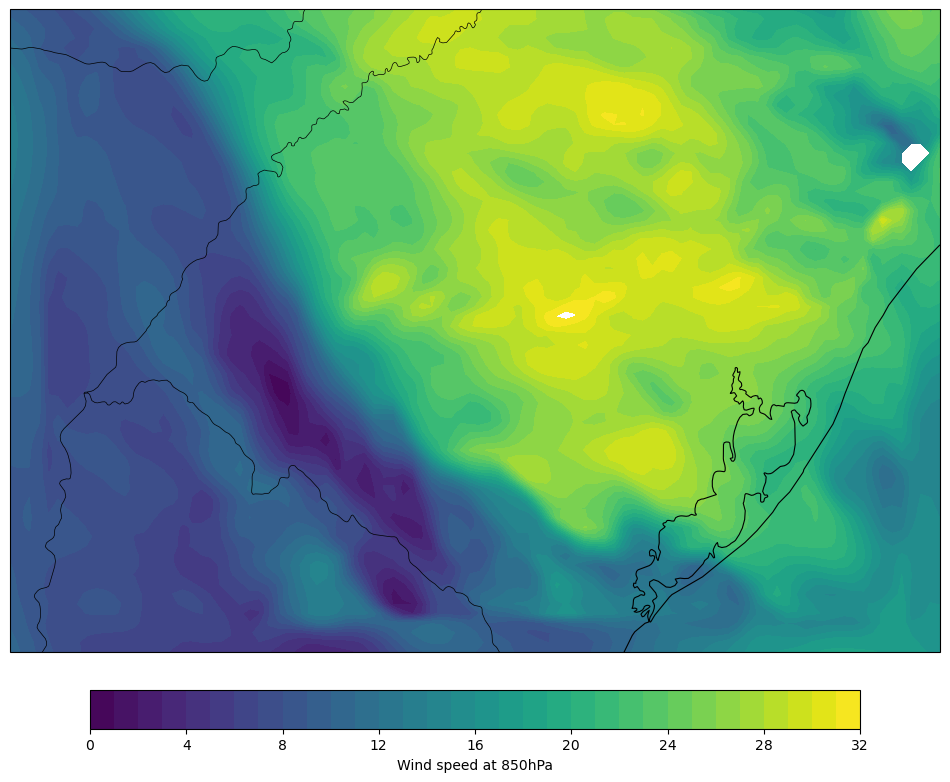

In [49]:
# Define de contour interval
data_min = 0
data_max = 32
interval = 1
levels = np.arange(data_min,data_max + interval,interval)

plt.figure(figsize=(12,10))

ax = plt.axes(projection=cart_proj)

img1 = ax.contourf(lons, lats, ws850, cmap='viridis',  levels=levels,transform=ccrs.PlateCarree())
    
# # Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='black', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 2), ylocs=np.arange(-90, 90, 2), draw_labels=True)
# gl.top_labels = False
# gl.right_labels = False

plt.colorbar(img1, label='Wind speed at 850hPa', orientation='horizontal', pad=0.05, fraction=0.05)

### **3.2) Overlaying Multiple Diagnostics**



#### Wind Speed Field at 850 hPa 

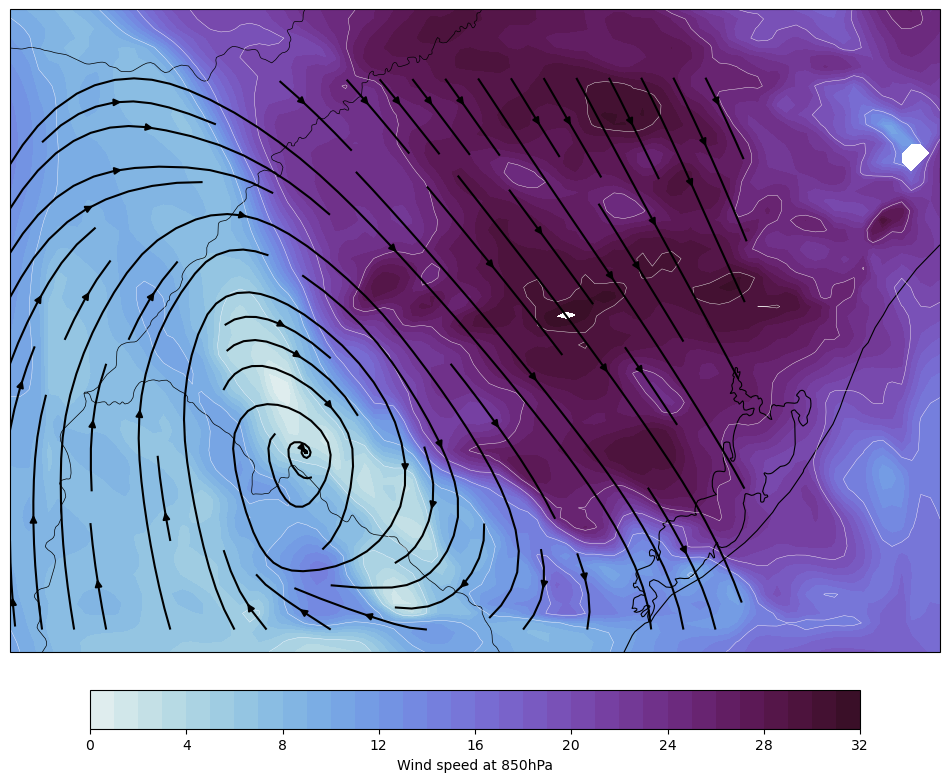

In [50]:
# Define de contour interval
data_min = 0
data_max = 32
interval = 1
levels = np.arange(data_min,data_max + interval,interval)

plt.figure(figsize=(12,10))

ax = plt.axes(projection=cart_proj)

img1 = ax.contourf(lons, lats, ws850, cmap=cmaps.cmocean_dense,  levels=levels,transform=ccrs.PlateCarree())
img2 = ax.contour(lons, lats, ws850, colors='white', linewidths=0.3, transform=ccrs.PlateCarree())

img3 = ax.streamplot(lons[::20, ::20], lats[::20,::20], u850[::20, ::20], v850[::20, ::20], color='black', transform=ccrs.PlateCarree())
    
# # Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='black', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 2), ylocs=np.arange(-90, 90, 2), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.colorbar(img1, label='Wind speed at 850hPa', orientation='horizontal', pad=0.05, fraction=0.05)

#### Dew point temp, sea level pressure, and winds

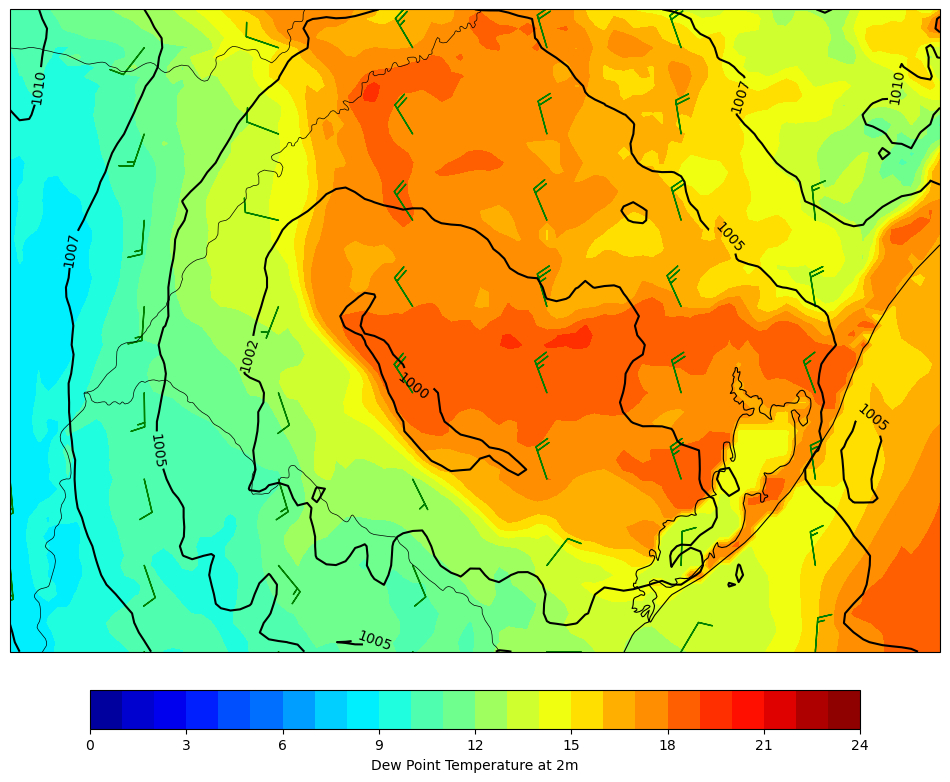

In [73]:
slp = getvar(wrf_file, "slp", timeidx=0)
td2 = getvar(wrf_file, "td2", timeidx=0, units="degC") 

u_sfc  = interplevel(u, p, 900)
v_sfc  = interplevel(v, p, 900)

plt.figure(figsize=(12,10))

ax = plt.axes(projection=cart_proj)

data_min = 980
data_max = 1030
interval = 2.5
levels_slp = np.arange(data_min,data_max + interval,interval)

data_min = 0
data_max = 24
interval = 1
levels_td = np.arange(data_min,data_max + interval,interval)

# Make sea level pressure contour lines.
img1 = plt.contour(lons, lats, slp, levels=levels_slp, colors='k', transform=crs.PlateCarree())
img2 = plt.contourf(lons, lats, td2, levels=levels_td, cmap=cmaps.matlab_jet,transform=crs.PlateCarree())

thin = [int(x/7.) for x in lons.shape]

img3 = plt.barbs(to_np(lons[::thin[0], ::thin[1]]), # Why are we using to_np here?
          to_np(lats[::thin[0], ::thin[1]]),
          to_np(u_sfc[::thin[0], ::thin[1]]),
          to_np(v_sfc[::thin[0], ::thin[1]]),
          transform=crs.PlateCarree(),
          color = 'green')


ax.coastlines(resolution='10m', color='black', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)

# Add contour labels for pressure
plt.clabel(img1, fmt="%i")

# Add a color bar
plt.colorbar(img2, label='Dew Point Temperature at 2m', orientation='horizontal', pad=0.05, fraction=0.05)

#### Cloud Top Temperature

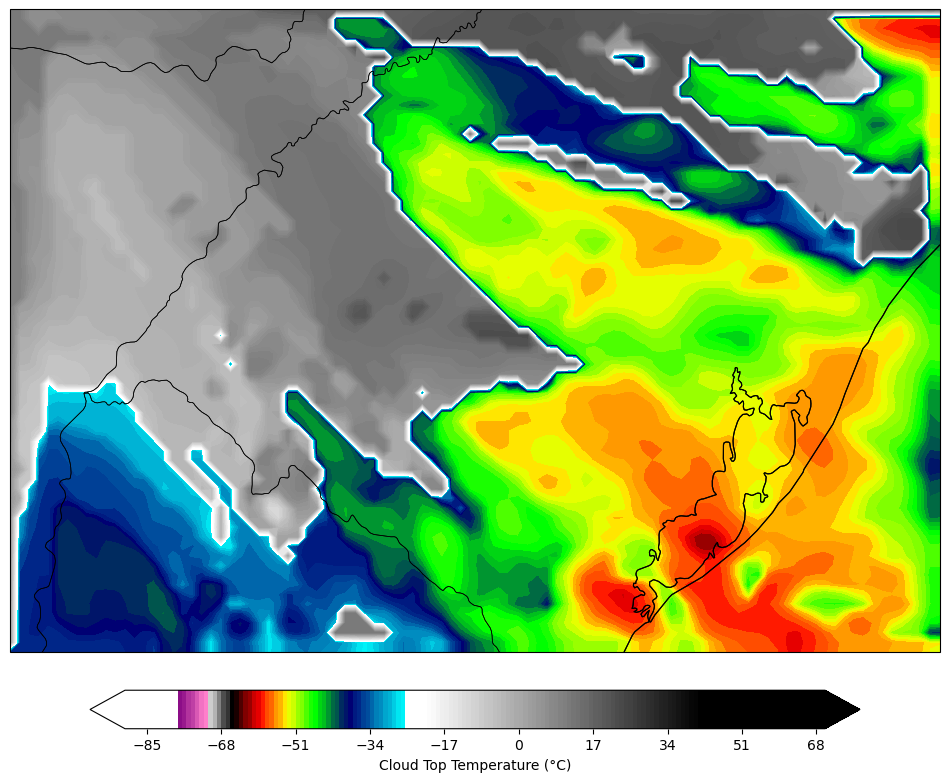

In [103]:
ctt = getvar(wrf_file,"ctt",timeidx=0,units='degC')

data_min = -90
data_max = 70
interval = 1
levels = np.arange(data_min,data_max + interval,interval)

cpt = loadCPT('IR4AVHRR6.cpt')
cpt_convert = LinearSegmentedColormap('cpt', cpt)

plt.figure(figsize=(12,10))

ax = plt.axes(projection=cart_proj)

img1 = ax.contourf(lons, lats, ctt, cmap=cpt_convert,extend="both",levels=levels,transform=ccrs.PlateCarree())

ax.coastlines(resolution='10m', color='black', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)

ax.coastlines(resolution='10m', color='black', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)

plt.colorbar(img1, label='Cloud Top Temperature (°C)', orientation='horizontal', pad=0.05, fraction=0.05)


### **4) Vertcross and Interpline function**

The idea is to draw a horizontal line at the surface, and the cross section is defined as a vertical plane extending up from this line. The new x-axis for a cross section plot is the points along the line you made. The line can be defined by:

- Defining a start point and an end point by using (x,y) grid coordinates or (latitude, longitude) coordinates.
- Defining a pivot point and an angle, which is useful for cross sections that will span most of the domain.

Two-dimensional fields can be interpolated along a line, in a manner similar to the vertical cross section, using the **interpline() function**. To define the line to interpolate along, a start point and an end point needs to be specified. 

In [148]:
start_point = CoordPair(lat=-32,lon=-53) 
end_point = CoordPair(lat=-32,lon=-50)

# Get the WRF variables
ht = getvar(wrf_file, "z", timeidx=-1)
ter = getvar(wrf_file, "ter",units='m',timeidx=-1)
dbz = getvar(wrf_file, "dbz", timeidx=-1)
max_dbz = getvar(wrf_file, "mdbz", timeidx=-1)
Z = 10**(dbz/10.) # Use linear Z for interpolation

z_cross = vertcross(Z, ht, wrfin=wrf_file,
                    start_point=start_point,
                    end_point=end_point,
                    latlon=True, meta=True)

# Get the terrain heights along the cross section line
ter_line = interpline(ter, wrfin=wrf_file, start_point=start_point,
                      end_point=end_point)

# Convert back to dBz after interpolation
dbz_cross = 10.0 * np.log10(z_cross)

# Add back the attributes that xarray dropped from the operations above
dbz_cross.attrs.update(z_cross.attrs)
dbz_cross.attrs["description"] = "radar reflectivity cross section"
dbz_cross.attrs["units"] = "dBZ"

print(dbz)

<xarray.DataArray 'dbz' (bottom_top: 44, south_north: 68, west_east: 98)> Size: 1MB
array([[[-30.       , -30.       , -30.       , ..., -30.       ,
         -30.       , -30.       ],
        [-30.       , -30.       , -30.       , ..., -30.       ,
         -30.       , -30.       ],
        [-30.       , -30.       ,  -0.8236199, ..., -30.       ,
         -30.       , -30.       ],
        ...,
        [-30.       , -30.       , -30.       , ..., -30.       ,
         -30.       , -30.       ],
        [-30.       , -30.       , -30.       , ..., -30.       ,
         -30.       , -30.       ],
        [-30.       , -30.       , -30.       , ..., -30.       ,
         -30.       , -30.       ]],

       [[-30.       , -30.       , -30.       , ..., -30.       ,
         -30.       , -30.       ],
        [-30.       , -30.       , -30.       , ..., -30.       ,
         -30.       , -30.       ],
        [-30.       , -30.       ,   0.7203827, ..., -30.       ,
         -30.      

Text(0, 0.5, 'Height (m)')

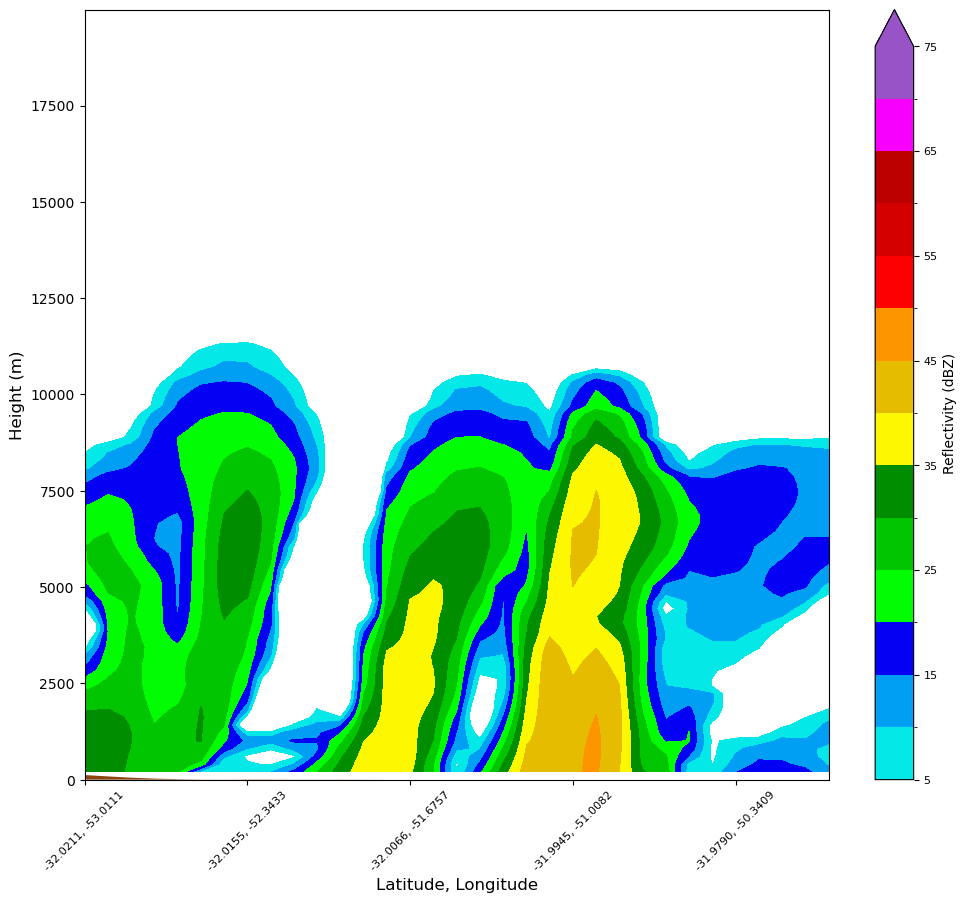

In [149]:

dbz_cross_filled = np.ma.copy(to_np(dbz_cross))

fig = plt.figure(figsize=(12,10))
ax_cross = plt.axes()

dbz_levels = np.arange(5., 75., 5.)

dbz_rgb = np.array([[4,233,231],
                    [1,159,244], [3,0,244],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198]], np.float32) / 255.0

dbz_map, dbz_norm = from_levels_and_colors(dbz_levels, dbz_rgb,
                                           extend="max")

data_min = 5
data_max = 75
interval = 5
levels = np.arange(data_min,data_max + interval,interval)

xs = np.arange(0, dbz_cross.shape[-1], 1)
ys = to_np(dbz_cross.coords["vertical"])
dbz_contours = ax_cross.contourf(xs,
                                 ys,
                                 to_np(dbz_cross_filled),
                                 levels=levels,
                                 cmap=dbz_map,
                                 norm=dbz_norm,
                                 extend="max")
# Add the color bar
cb_dbz = fig.colorbar(dbz_contours, ax=ax_cross, label='Reflectivity (dBZ)')
cb_dbz.ax.tick_params(labelsize=8)

# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]

ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line),
                                facecolor="saddlebrown")

# Set the desired number of x ticks below
num_ticks = 5
thin = int((len(x_ticks) / num_ticks) + .5)
ax_cross.set_xticks(x_ticks[::thin])
ax_cross.set_xticklabels(x_labels[::thin], rotation=45, fontsize=8)

# Set the x-axis and  y-axis labels
ax_cross.set_xlabel("Latitude, Longitude", fontsize=12)
ax_cross.set_ylabel("Height (m)", fontsize=12)

### **5) Lat/Lon <-> XY Routines**


In some cases, it is necessary to know the values ​​of a specific point. Remembering that we have a shape (level, x, y), we need something to find the values ​​of x and y referring to the latitude and longitude that we need. For this, we use **ll_to_xy**:

In [171]:
### Latitude and Longitude of Santa Maria ###
lon = -53.8008
lat = -29.6914

x_y = ll_to_xy(wrf_file, lat, lon)
 
print (x_y)

lat_lon = xy_to_ll(wrf_file, 60, 50)

print(lat_lon)

<xarray.DataArray 'xy' (x_y: 2)> Size: 16B
array([49, 34])
Coordinates:
    latlon_coord  object 8B CoordPair(lat=-29.6914, lon=-53.8008)
  * x_y           (x_y) <U1 8B 'x' 'y'
<xarray.DataArray 'latlon' (lat_lon: 2)> Size: 16B
array([-28.37716834, -52.76419715])
Coordinates:
    xy_coord  object 8B CoordPair(x=60, y=50)
  * lat_lon   (lat_lon) <U3 24B 'lat' 'lon'


But why would this be necessary? In some cases where we need to analyze the thermodynamics of the environment in question, and for this, we will create a skew-t. To do this, we will use metpy as an additional library.

926.2784239462184 hectopascal 16.854760552312086 degree_Celsius


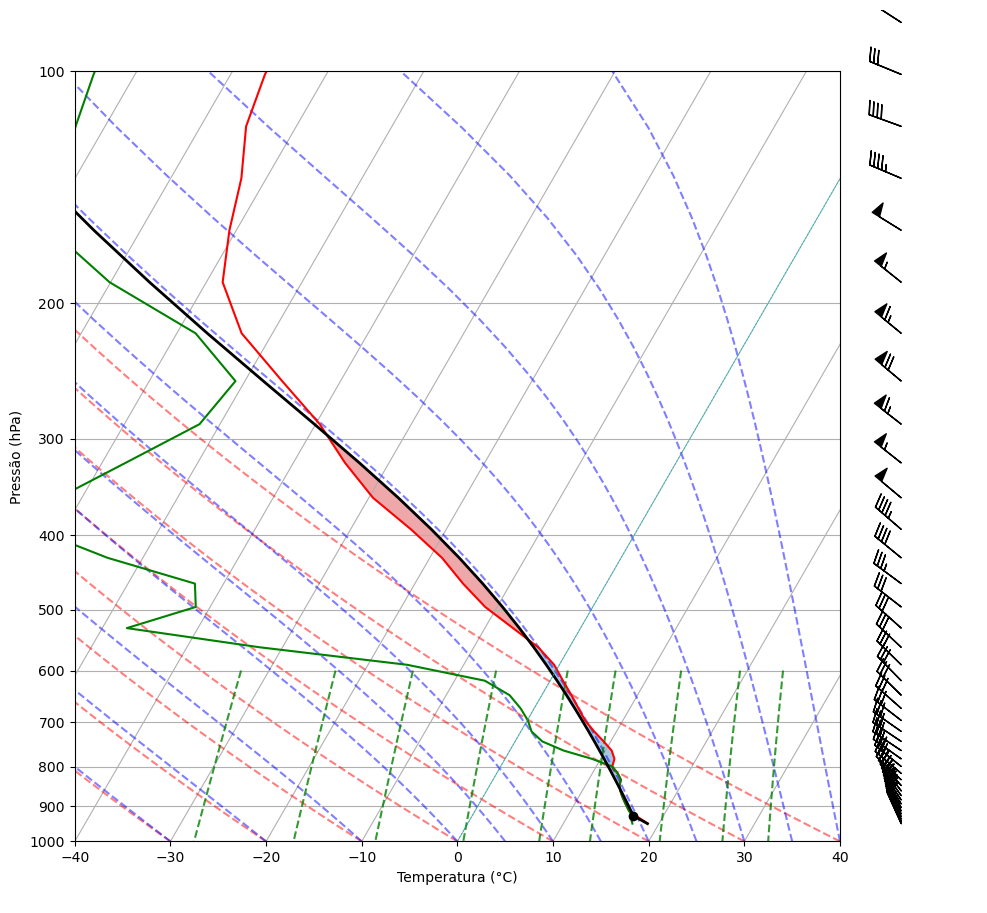

In [ ]:
fig = plt.figure(figsize=(12, 10))
skew = SkewT(fig)

date = getvar(wrf_file,'times')
temp = getvar(wrf_file,'tc')[:,38,49].data * units.degC
rh = getvar(wrf_file,'rh')[:,38,49].data * units.percent
u = getvar(wrf_file,'ua',units='m/s')[:,38,49].data * units.knots
v = getvar(wrf_file,'va',units='m/s')[:,38,49].data * units.knots
p = getvar(wrf_file,'pressure')[:,38,49].data * units.hPa

td = mpcalc.dewpoint_from_relative_humidity(temp, rh) 
wind_speed = mpcalc.wind_speed(u, v)

# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], temp[0], td[0])

print(lcl_pressure, lcl_temperature)

# # Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, temp[0], td[0]).to('degC')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, temp, 'r')
skew.plot(p, td, 'g')
skew.plot_barbs(p, u, v, xloc=1.08)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 40)

# Set some better labels than the default
skew.ax.set_xlabel(f'Temperature ({temp.units:~P})')
skew.ax.set_ylabel(f'Pressure ({p.units:~P})')

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# # Shade areas of CAPE and CIN
skew.shade_cin(p, temp, parcel_prof, td)
skew.shade_cape(p, temp, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=0.5)

#Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()




In [ ]:
### Reading multiple files and inspect the variables ###

PATH = "/home/douglas/WRF-Python/data/wrfout_d01_2022-*"

for filepath in sorted(glob.glob(PATH)):
    print(f"Processing: {filepath}")
    wrf_file = Dataset(filepath)

    var = wrf_file.variables['T2']

    print('The temperature at 2m in the domain', var)